In [1]:
import pickle
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from os import listdir
from os.path import join
from datetime import datetime
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.utils import plot_model
from keras.models import Sequential
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, LSTM, Reshape, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATA_PATH = "/kaggle/input/rain-seq-master-precise-stiched"
AUDIO_PATH = "/kaggle/input/rain-seq-master-precise-stiched/data"
BASIC_DATA_PATH = join(DATA_PATH, "data_basic.csv")
Fs = 8000
model_name="seq_stft.hdf5"
SEQ_LEN = 1368000 # 171 seconds @ Fs 8k samples/sec
LEARNING_RATE = 0.001

In [3]:
def find_zero_point_percentage(df):
    df_non_zero = df[df["target"]!=0]
    df_zero = df[df["target"]==0]
    T = df.shape[0]
    non_zeros = df_non_zero.shape[0]
    zeros = df_zero.shape[0]
    print("Percentage of Zero datapoints: ",zeros*100/T, "%")

In [4]:
basic_data = pd.read_csv(BASIC_DATA_PATH)
basic_data = basic_data[["checkpoint","fname","target"]]
basic_data["checkpoint"] = pd.to_datetime(basic_data["checkpoint"])

In [5]:
basic_data = basic_data.drop_duplicates(subset=["checkpoint"])

In [6]:
# filter_date = pd.Timestamp("2024-01-01")
# basic_data = basic_data[basic_data["checkpoint"] > filter_date]

In [7]:
basic_data

,checkpoint,fname,target
0,2023-11-22 18:27:26,audio_0.wav,0.8
1,2023-11-22 18:30:26,audio_1.wav,1.4
2,2023-11-22 18:33:26,audio_2.wav,1.0
3,2023-11-22 18:36:26,audio_3.wav,1.4
4,2023-11-22 18:39:26,audio_4.wav,0.2
...,...,...,...
1061,2024-05-29 16:20:56,audio_1339.wav,0.6
1062,2024-05-29 16:23:56,audio_1340.wav,0.6
1063,2024-05-29 16:26:56,audio_1341.wav,0.6
1064,2024-05-29 17:05:56,audio_1345.wav,0.6


In [8]:
find_zero_point_percentage(basic_data)

Percentage of Zero datapoints:  23.639774859287055 %


In [9]:
basic_data_non_zero = basic_data[basic_data["target"]!=0.0]
basic_data_zero = basic_data[basic_data["target"]==0.0]
basic_data_zero = basic_data_zero.sample(n=30)
basic_data_merged = pd.concat([basic_data_non_zero, basic_data_zero], ignore_index=True)
basic_data = basic_data_merged.sample(frac=1)
basic_data.sort_values(by="checkpoint")

,checkpoint,fname,target
0,2023-11-22 18:27:26,audio_0.wav,0.8
1,2023-11-22 18:30:26,audio_1.wav,1.4
2,2023-11-22 18:33:26,audio_2.wav,1.0
3,2023-11-22 18:36:26,audio_3.wav,1.4
4,2023-11-22 18:39:26,audio_4.wav,0.2
...,...,...,...
809,2024-05-29 16:20:56,audio_1339.wav,0.6
810,2024-05-29 16:23:56,audio_1340.wav,0.6
811,2024-05-29 16:26:56,audio_1341.wav,0.6
812,2024-05-29 17:05:56,audio_1345.wav,0.6


In [10]:
# basic_data = basic_data[basic_data["target"]<4]

<Axes: >

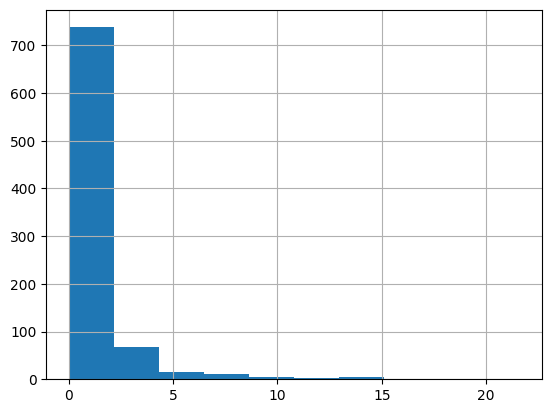

In [11]:
basic_data["target"].hist()

In [12]:
basic_data["target"].value_counts()

target
0.2     295
0.6     163
0.4     117
1.2      62
1.8      31
0.0      30
0.8      15
2.4      14
3.0      14
3.6      10
1.0       9
4.2       9
4.8       8
2.6       7
1.6       7
1.4       5
5.4       5
7.8       4
2.0       4
9.0       3
3.2       3
3.8       3
2.2       2
7.2       2
7.6       2
2.8       2
3.4       2
8.4       1
5.8       1
9.6       1
14.2      1
4.0       1
8.0       1
13.0      1
6.0       1
6.6       1
11.6      1
11.0      1
13.2      1
19.2      1
5.2       1
21.6      1
13.8      1
Name: count, dtype: int64

In [13]:
find_zero_point_percentage(basic_data)

Percentage of Zero datapoints:  3.5545023696682465 %


In [14]:
basic_data

,checkpoint,fname,target
436,2024-05-17 18:11:07,audio_798.wav,1.2
296,2023-12-17 13:02:35,audio_480.wav,0.4
142,2023-12-17 04:29:35,audio_319.wav,0.2
843,2023-11-22 20:36:26,audio_35.wav,0.0
507,2024-05-21 07:48:49,audio_928.wav,3.6
...,...,...,...
219,2023-12-17 09:11:35,audio_403.wav,0.4
514,2024-05-21 16:04:31,audio_936.wav,13.8
790,2024-05-29 14:26:56,audio_1316.wav,1.8
31,2023-11-22 21:57:26,audio_57.wav,1.0


In [15]:
class Dataset:
    def __init__(self, basic_data, data_path, output_shape, validation=False):
        self.basic_data = basic_data
        self.y = self.basic_data["target"].values
        self.X = self.basic_data["fname"].values
        self.data_path = data_path
        self.validation = validation
        self.output_shape = output_shape
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y,
                                                                                test_size=0.25)
    def __len__(self):
        if self.validation:
            data_len = int(np.ceil(len(self.y_test)))
        else:
            data_len = int(np.ceil(len(self.y_train)))
        return int(np.ceil(data_len))
    
    def create_cnn_data(self, raw_data):
        Zxx = librosa.stft(raw_data)
        stft_sample = np.abs(Zxx)
        return stft_sample
    
    def create_mfcc_data(self, raw_data):
        mfcc = librosa.feature.mfcc(y=raw_data, sr=Fs, n_mfcc=13)
        return mfcc
    
    def create_chroma_stft_data(self, raw_data):
        chroma = librosa.feature.chroma_stft(y=raw_data, sr=Fs)
        return chroma

    def __getitem__(self, index):
        if self.validation:
            audio_file = self.X_test[index]
            batch_target = self.y_test[index]
        else:
            audio_file = self.X_train[index]
            batch_target = self.y_train[index]
        audio_file = audio_file.split(".")[0]+".npy"
        audio_data = np.load(join(self.data_path, audio_file))
        audio_data = audio_data[:SEQ_LEN]
        
        features = self.create_cnn_data(audio_data)
#         features = self.create_mfcc_data(audio_data)
#         features = self.create_chroma_stft_data(audio_data)
        
        batch_target = batch_target.reshape(self.output_shape)

        return features, batch_target

In [16]:
class Dataloder(Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [17]:
EPOCHS = 30
BATCH_SIZE = 8
output_shape = (1, 1)

In [18]:
train_dataset = Dataset(basic_data,
                        AUDIO_PATH,
                        output_shape)

train_dataloader = Dataloder(train_dataset, 
                             batch_size=BATCH_SIZE)

test_dataset = Dataset(basic_data,
                       AUDIO_PATH,
                       output_shape,
                       validation=True)

test_dataloader = Dataloder(test_dataset, 
                            batch_size=BATCH_SIZE)

In [19]:
adamopt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [20]:
def create_functional_model():
    model = Sequential()
    model.add(Input((1025, 2672, 1)))
    model.add(Conv2D(64, kernel_size=(8, 8), activation="relu"))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Conv2D(32, kernel_size=(4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(16, kernel_size=(2, 2), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Reshape((1, -1)))
    model.add(LSTM(20))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(1))
    return model

In [21]:
model = create_functional_model()

In [22]:
# plot_model(model,
#            to_file="rain_gauge_model.png",
#            show_shapes=True,
#            dpi=100)

In [23]:
cp_callback = ModelCheckpoint(filepath=model_name,
                              monitor="val_loss",
                              verbose=0,
                              save_best_only=True,
                              save_weights_only=True,
                              mode="min")

In [24]:
model.compile(optimizer= adamopt, loss="mean_squared_error", metrics=["mse"])

In [25]:
history = model.fit(train_dataloader,
                    validation_data=test_dataloader,
                    epochs=EPOCHS,
                    callbacks=[cp_callback])

Epoch 1/30
79/79 [==============================] - 102s 1s/step - loss: 2.7259 - mse: 2.7259 - val_loss: 1.8745 - val_mse: 1.8745
Epoch 2/30
79/79 [==============================] - 69s 875ms/step - loss: 2.3880 - mse: 2.3880 - val_loss: 1.6846 - val_mse: 1.6846
Epoch 3/30
79/79 [==============================] - 69s 870ms/step - loss: 2.0853 - mse: 2.0853 - val_loss: 2.7506 - val_mse: 2.7506
Epoch 4/30
79/79 [==============================] - 68s 858ms/step - loss: 2.3453 - mse: 2.3453 - val_loss: 1.6779 - val_mse: 1.6779
Epoch 5/30
79/79 [==============================] - 68s 859ms/step - loss: 2.1192 - mse: 2.1192 - val_loss: 1.8539 - val_mse: 1.8539
Epoch 6/30
79/79 [==============================] - 67s 854ms/step - loss: 1.7590 - mse: 1.7590 - val_loss: 1.4254 - val_mse: 1.4254
Epoch 7/30
79/79 [==============================] - 68s 865ms/step - loss: 1.3502 - mse: 1.3502 - val_loss: 1.2403 - val_mse: 1.2403
Epoch 8/30
79/79 [==============================] - 68s 861ms/step - lo

In [26]:
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [27]:
def plot_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("log Loss")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

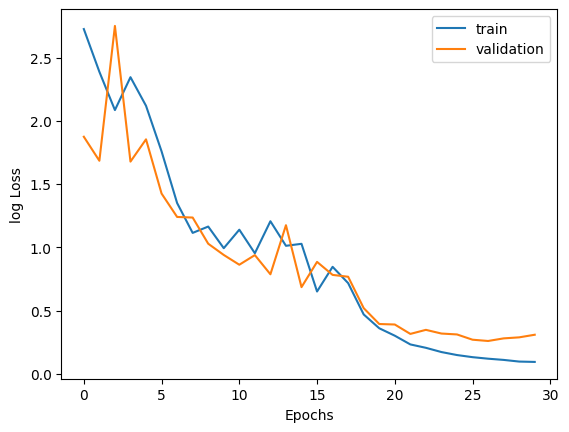

In [28]:
plot_history(history)

In [29]:
model.load_weights(model_name)

In [30]:
y_preds = []
y_tests = []
n_test = test_dataloader.__len__()
for i in tqdm(range(n_test)):
    X_test, y_test = test_dataloader.__getitem__(i)
    y_tests.extend(y_test.flatten())
    y_pred = model.predict(X_test, verbose=0).flatten()
    y_preds.extend(y_pred)
result_df = pd.DataFrame()
result_df["y_tests"] = y_tests
result_df["y_preds"] = y_preds

100%|██████████| 26/26 [00:24<00:00,  1.07it/s]


In [31]:
# outliers =  [1, 11, 25, 39]
# result_df = result_df.loc[~result_df.index.isin(outliers)]
# result_df = result_df[result_df["y_tests"]!=0]

Text(0, 0.5, 'Rainfall acoustic (mm) (estimated)')

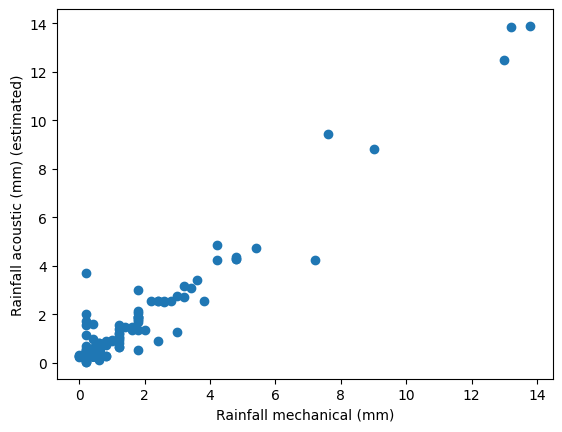

In [32]:
plt.scatter(result_df["y_tests"], result_df["y_preds"])
plt.xlabel("Rainfall mechanical (mm)")
plt.ylabel("Rainfall acoustic (mm) (estimated)")

In [33]:
result_df

,y_tests,y_preds
0,0.6,0.352114
1,0.6,0.597126
2,0.2,0.237953
3,13.2,13.828427
4,0.8,0.887760
...,...,...
203,0.4,0.296331
204,0.2,0.296514
205,0.2,0.296321
206,0.2,0.358646


In [34]:
result = result_df[(result_df["y_tests"]!=0.0)]
A = result["y_tests"]
F = result["y_preds"]
N = result.shape[0]
MAPE = np.sum(abs((A-F)/(A+0.00001)))*100/N
print("Mean Absolute Percentage Error: {}%".format(np.round(MAPE, 3)))

Mean Absolute Percentage Error: 61.357%


In [35]:
result_df.corr(method='spearman')

,y_tests,y_preds
y_tests,1.000000,0.669329
y_preds,0.669329,1.000000


In [36]:
print("R2 score: ", r2_score(result_df["y_tests"], result_df["y_preds"]))

R2 score:  0.9337642989987405


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [37]:
result_df.to_csv("result_df.csv")